In [122]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 

import numpy as np
import matplotlib.pyplot as plt

#### Structure 
- general 
    - down sample (pool conv - conv relu  ) 
    - upsample 
    - SE block ad additive thing before pooling
- U net simple 
    - encoder
    - decoder
    


### Activation 

In [2]:
def h_sigmoid(x):
    return tf.nn.relu6(x + 3) / 6


def h_swish(x):
    return x * h_sigmoid(x)

def FRelu_complex(x, n_channels = 1):
    n_channels = x.shape[-1]
    conditional = layers.Conv2D(n_channels, (3, 3),  padding = 'same')(x)
    activation = layers.Maximum()([x, conditional])
    return activation


### SE block

(None, 32, 32, 191)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 191) 0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 191)          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 1, 191)]     0           global_average_pooling2d[0][0]   
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 1, 1, 191)]  0           tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________

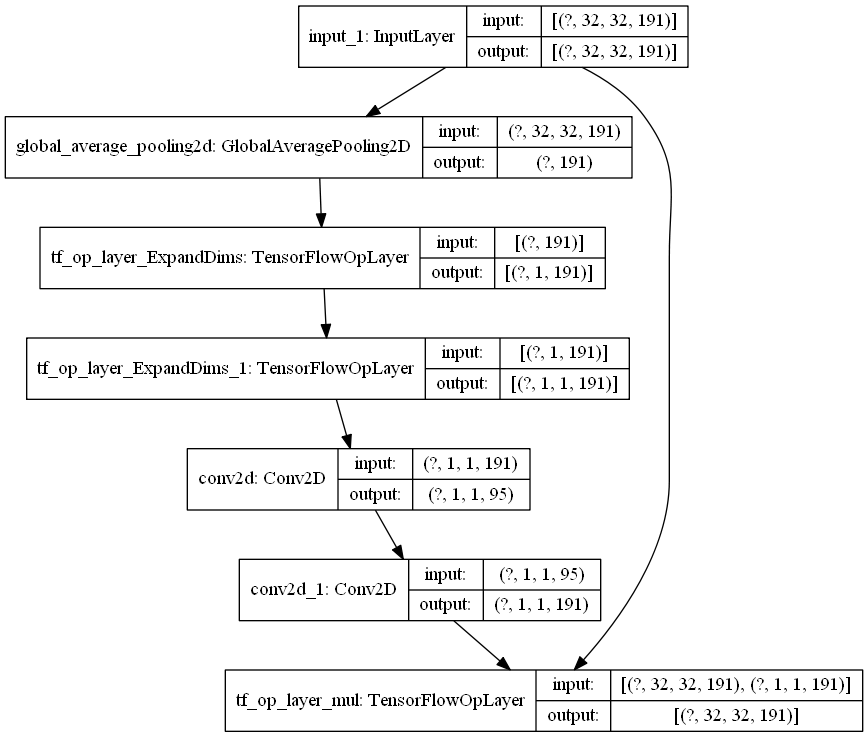

In [3]:
def SE_block(x, r = 2):
    print(x.shape)
    branch = layers.GlobalAveragePooling2D()(x)
    n_channels = branch.shape[-1]
    branch = tf.expand_dims(branch, axis = 1)
    branch = tf.expand_dims(branch, axis = 1)
    
    branch = layers.Conv2D(n_channels // r, (1, 1) , padding = 'same', activation = 'relu')(branch)
    
    branch = layers.Conv2D(n_channels, 1, padding = 'same', activation = 'relu')(branch)
    
    output = x * branch
    return output


x_example = np.random.rand(32, 32, 191)
inputs =  layers.Input(x_example.shape)  
# print(inputs.shape)
output = SE_block(inputs)
# print(inputs.shape)

model = keras.Model(inputs, output) 
model.summary()


y_hat = model.predict(x_example[np.newaxis, :])
print('Information ', 
      '\ninput size: ', x_example.shape, 
      '\noutput size ', y_hat.shape)

tf.keras.utils.plot_model(model, show_shapes=True)

## WRITE FUNCTIONS 
- downsample
- upsample

In [70]:

def downsample(x, n_filters, filter_size, pool = (2, 2), padding="same", how_conv = 'conv', times = 2):
    x = layers.MaxPool2D(pool_size=pool)(x)
    if how_conv == 'conv':
        for i in range(times):
            x = layers.Conv2D(n_filters, filter_size, padding=padding)(x)
        x = layers.Activation('relu')(x)
        #intersting approach. should try. 
#         x = FRelu_complex(x)
    
    elif how_conv =='sep_conv':
        for i in range(times):
            x = layers.SeparableConv2D(n_filters, filter_size, padding = padding)(x)
        x = layers.Activation('relu')(x)
    else:
        pass
    return x 


def upsample(x, n_filters, filter_size = 3, scale = 2,  how = 'deconv'):
    if how == 'deconv':
        x = layers.UpSampling2D(scale)(x)
        x = layers.Conv2D(n_filters, filter_size, padding='same')(x)
        return x
    elif how =='sub_pixel':
        x = layers.Conv2D(n_filters * (scale**2), filter_size, padding='same')(x)
        SubPixLayer = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size = scale))
        out = SubPixLayer(x)

        return out
    else:
        print('Error. mistake in upsample techique')



## Model U-Net


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_252 (Conv2D)             (None, 512, 512, 8)  224         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 512, 512, 8)  584         conv2d_252[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_51 (MaxPooling2D) (None, 256, 256, 8)  0           conv2d_253[0][0]                 
___________________________________________________________________________________________

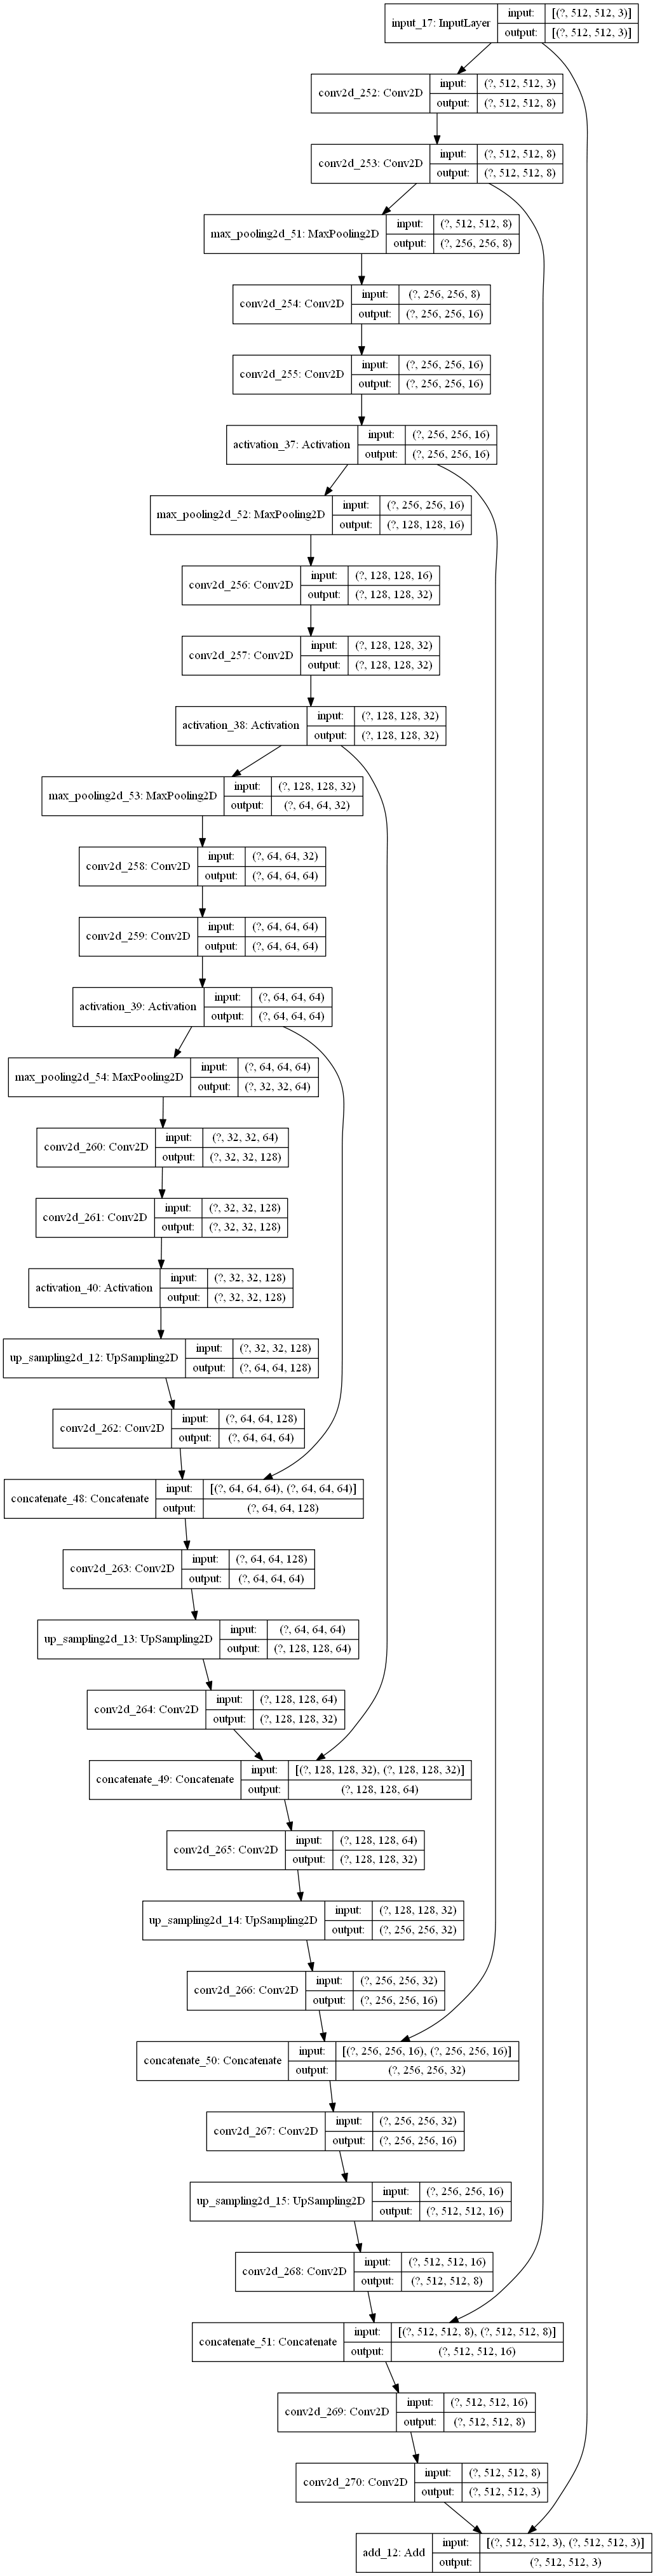

In [123]:

def UNet(input_shape = [32, 32, 3], features_maps= [64, 128, 256,512, 1028]):
    def downsample(x, n_filters, filter_size, pool = (2, 2), padding="same", how_conv = 'conv', times = 2):
        x = layers.MaxPool2D(pool_size=pool)(x)
        if how_conv == 'conv':
            for i in range(times):
                x = layers.Conv2D(n_filters, filter_size, padding=padding)(x)
            x = layers.Activation('relu')(x)
            #intersting approach. should try. 
    #         x = FRelu_complex(x)

        elif how_conv =='sep_conv':
            for i in range(times):
                x = layers.SeparableConv2D(n_filters, filter_size, padding = padding)(x)
            x = layers.Activation('relu')(x)
        else:
            pass
        return x 


    def upsample(x, n_filters, filter_size = 3, scale = 2,  how = 'deconv'):
        if how == 'deconv':
            x = layers.UpSampling2D(scale)(x)
            x = layers.Conv2D(n_filters, filter_size, padding='same')(x)
            return x
        elif how =='sub_pixel':
            x = layers.Conv2D(n_filters * (scale**2), filter_size, padding='same')(x)
            SubPixLayer = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size = scale))
            out = SubPixLayer(x)

            return out
        else:
            print('Error. mistake in upsample techique')

    
    
    
    
    inputs =  layers.Input(input_shape)  
    # encoder
    conv1 = layers.Conv2D(features_maps[0], 3, padding = 'same',  activation = 'relu')(inputs)
    conv1 = layers.Conv2D(features_maps[0], 3, padding = 'same', activation = 'relu')(conv1)
    
    conv2 = downsample(conv1, n_filters = features_maps[1], filter_size = 3) #256
    conv3 = downsample(conv2, n_filters = features_maps[2], filter_size = 3) #128
    conv4 = downsample(conv3, n_filters = features_maps[3], filter_size = 3) #64
    conv5 = downsample(conv4, n_filters = features_maps[4], filter_size = 3) #32
    
    
    # decoder
    how_upsample = 'deconv'
    up6 = upsample(conv5 , n_filters = features_maps[3], filter_size = 2, how = how_upsample)
    merge6 = layers.concatenate([conv4, up6], axis = -1)
    conv6 = layers.Conv2D(features_maps[3], 3, padding = 'same', activation = 'relu')(merge6)
    
    up7 = upsample(conv6 , n_filters = features_maps[2], filter_size = 2, how = how_upsample)
    merge7 = layers.concatenate([conv3, up7], axis = -1)
    conv7 = layers.Conv2D(features_maps[2], 3, padding = 'same', activation = 'relu')(merge7)
    
    up8 = upsample(conv7 , n_filters = features_maps[1], filter_size = 2, how = how_upsample)
    merge8 = layers.concatenate([conv2, up8], axis = -1)
    conv8 = layers.Conv2D(features_maps[1], 3, padding = 'same', activation = 'relu')(merge8)
    
    up9 = upsample(conv8 , n_filters = features_maps[0], filter_size = 2, how = how_upsample)
    merge9 = layers.concatenate([conv1, up9], axis = -1)
    conv9 = layers.Conv2D(features_maps[0], 3, padding = 'same', activation = 'relu')(merge9)
    conv9 = layers.Conv2D(3, 3, padding = 'same', activation = 'relu')(conv9)
    
    output = conv9
    result = layers.Add()([inputs, output])
    
    
    model = keras.Model(inputs, result)
    return model

model = UNet(input_shape = [512,512,3], features_maps= [8,16,32,64,128])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model_Unet.png')

## Traning Loop

In [124]:
model = UNet(input_shape = [32,32,3], features_maps= [8,16,32,64,128])

In [104]:
optimizer = keras.optimizers.SGD(lr = 1e-3)
loss_fn = keras.losses.MeanSquaredError()

#prepare the training dataset
x = np.random.rand(10000, 784).astype('float32')
x_noise = (np.random.rand(10000, 784)/10).astype('float32')
y = x + x_noise
y = y / y.max()

train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)



In [102]:
epochs = 2
for epoch in range(epochs):
    print('Start epoch: ', epoch)
    for step, (x_batch, y_batch) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            target = model(x_batch, training = True)
            print(target.shape)
            loss_value = loss_fn(y_batch, x_batch)
            print(loss_value)
            
        grads = tape.gradient(loss_value, model.trainable_weights)
        print(grads)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        if step %20 == 0:
            print('Training loss at step %d: %.4f').format(step, float(loss_value))
            print("Samples: ", (step + 1 )*batch_size)
        

Start epoch:  0
(64, 10)
tf.Tensor(0.001379864, shape=(), dtype=float32)
[None, None, None, None, None, None]


ValueError: No gradients provided for any variable: ['dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0', 'predictions/kernel:0', 'predictions/bias:0'].

## Utils 

In [6]:
def plot_image(image, title=""):
    """
    Plots images from image tensors.
    Args:
    image: 3D image tensor. [height, width, channels].
    title: Title to display in the plot.
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

In [9]:
def minigooglenet_functional(width, height, depth, classes):
	def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
		# define a CONV => BN => RELU pattern
		x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Activation("relu")(x)
		# return the block
		return 

In [11]:
initial_learning_rate_generator = 1e-3

step_decay = 1e-2

boundaries = [500]

step_decay_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, [initial_learning_rate_generator, initial_learning_rate_generator*step_decay])


In [12]:
generator_optimizer = tf.keras.optimizers.Adam(step_decay_gen)

In [13]:
checkpoint_dir = '/training_checkpoints/' + datetime.now().strftime("%Y%m%d-%H%M%S")



NameError: name 'datetime' is not defined

In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape:
        output = U_net(input_image, training=True)        
        l1_loss = generator_loss(gen_output, target)       

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))   
    
    return gen_total_loss, gen_l1_loss, ms_ssim_loss    
    

In [125]:
model = UNet(input_shape = [32,32,3], features_maps= [8,16,32,64,128])


In [149]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()

# Prepare the training dataset.
batch_size = 64
x_train = np.random.rand(10000, 32, 32, 3).astype('float32')
y_train = np.random.rand(10000, 32, 32, 3).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10).batch(batch_size)

In [150]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 20 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))


Start of epoch 0
Training loss (for one batch) at step 0: 0.1689
Seen so far: 64 samples
Training loss (for one batch) at step 20: 0.1681
Seen so far: 1344 samples
Training loss (for one batch) at step 40: 0.1686
Seen so far: 2624 samples
Training loss (for one batch) at step 60: 0.1672
Seen so far: 3904 samples
Training loss (for one batch) at step 80: 0.1673
Seen so far: 5184 samples
Training loss (for one batch) at step 100: 0.1667
Seen so far: 6464 samples
Training loss (for one batch) at step 120: 0.1675
Seen so far: 7744 samples
Training loss (for one batch) at step 140: 0.1668
Seen so far: 9024 samples

Start of epoch 1
Training loss (for one batch) at step 0: 0.1672
Seen so far: 64 samples
Training loss (for one batch) at step 20: 0.1671
Seen so far: 1344 samples
Training loss (for one batch) at step 40: 0.1676
Seen so far: 2624 samples
Training loss (for one batch) at step 60: 0.1664
Seen so far: 3904 samples
Training loss (for one batch) at step 80: 0.1668
Seen so far: 5184 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


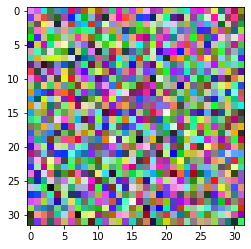

In [135]:
plt.imshow(model(x_train[0][np.newaxis, :])[0])

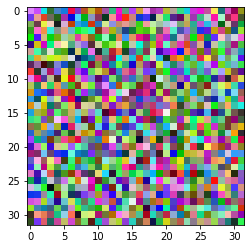

In [136]:
plt.imshow(x_train[0])

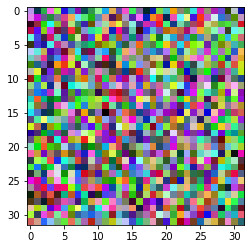

In [137]:
plt.imshow(y_train[0])

In [147]:
print(loss_fn(x_train[20], y_train[20]))
print(loss_fn(model(x_train[20][np.newaxis, :])[0],  y_train[20]))

tf.Tensor(0.17125234, shape=(), dtype=float32)
tf.Tensor(0.1738407, shape=(), dtype=float32)
